In [119]:
import pandas as pd
import matplotlib.pyplot as plt
# Import random forest model from sklearn
from sklearn.ensemble import RandomForestRegressor
# Import decision tree model from sklearn
from sklearn.tree import DecisionTreeRegressor, plot_tree
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split 
# Standard scaler
from sklearn.preprocessing import StandardScaler, Normalizer

# Load final data
df = pd.read_csv('data/jobs_step_1_final.csv')

x_cols = [
    'priority',
    'required-memory',
    'required-CPUs',
    'allocation_nodes',
    'steps-time-elapsed',
    
    'tres-allocated-cpu',
    'tres-allocated-mem',
    'tres-allocated-node',

    # # Categorical to one-hot
    # 'flags',
    # 'constraints',
    # 'state-reason',
    
    #'steps-tres-requested-total-mem',
    #'steps-tres-requested-total-vmem',
]

y_cols = [
    'steps-tres-consumed-total-energy',
    'steps-statistics-energy-consumed',
]

X, Y = df[x_cols], df[y_cols]

# #one-hot encoding
# X = pd.get_dummies(X, columns=['flags', 'constraints', 'state-reason'])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Reset index
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

# Fit standard scaler to X
scaler = StandardScaler()
scaler.fit(X_train)

normalizer = Normalizer()
normalizer.fit(X_train)

X_train.shape

(5565, 8)

In [120]:
# # Create random forest model
hyperparams = {
    'n_estimators': 15,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': 4,
}

hyperparams1 = {
    'n_estimators': 100,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': 4,
}

model = RandomForestRegressor(**hyperparams)
model1 = RandomForestRegressor(**hyperparams1)

In [121]:
# Fit 
model = model.fit(X_train, y_train[y_cols[0]])
model1 = model1.fit(X_train, y_train[y_cols[1]])

# # Plot Random Forest
# fig, ax = plt.subplots(2,2, figsize=(20, 10))
# ax = ax.flatten()
# for i, tree in enumerate(model.estimators_):
#     plot_tree(tree, filled=True, feature_names=X_test.columns, class_names=y_cols[0], ax=ax[i])
# plt.savefig('images/random_forest.png', dpi=300)

# Print importance of features
print(f'Feature importance for Random Forest Regression for {y_cols[0]}')
print(sorted([(round(model.feature_importances_[i], 3), col) for i, col in enumerate(X_test.columns)], reverse=True))
print('-' * 50)

print(f'Feature importance for Random Forest Regression for {y_cols[1]}')
print(sorted([(round(model1.feature_importances_[i], 3), col) for i, col in enumerate(X_test.columns)], reverse=True))
print('-' * 50)

# Print test score
print('Test scores for Random Forest Regression')
print('-' * 50)
print(f'R2 Score for {y_cols[0]}: {model.score(X_test, y_test[y_cols[0]]):.4f}')
print(f'R2 Score for {y_cols[1]}: {model1.score(X_test, y_test[y_cols[1]]):.4f}')

# Calculate the absolute errors
ab_total = (model.predict(X_test) - y_test[y_cols[0]]).abs()
ab_statistic = (model1.predict(X_test) - y_test[y_cols[1]]).abs()

# Calculate the mean squared error
mse_total = (ab_total**2).mean()
mse_statistic = (ab_statistic**2).mean()

# Print out the mean absolute error (mae)
print('-' * 50)
print(f'Mean Absolute Error for {y_cols[0]}: {ab_total.mean():.4f} kWh')
print(f'Mean Absolute Error for {y_cols[1]}: {ab_statistic.mean():.4f} joule or {ab_statistic.mean() * (2.7778 * (10**-7)):.4f} kWh')

# Keep in mind the standard deviation of the target variable
print('-' * 50)
print(f'Mean of {y_cols[0]}: {y_test[y_cols[0]].mean():.2f} kWh')
print(f'Standard deviation of {y_cols[0]}: {y_test[y_cols[0]].std():.2f} kWh')
print(f'Mean of {y_cols[1]}: {y_test[y_cols[1]].mean():.2f} joule or {y_test[y_cols[1]].mean() * (2.7778 * (10**-7)):.2f} kWh')
print(f'Standard deviation of {y_cols[1]}: {y_test[y_cols[1]].std():.2f} joule or {y_test[y_cols[1]].std() * (2.7778 * (10**-7)):.2f} kWh')

Feature importance for Random Forest Regression for steps-tres-consumed-total-energy
[(0.392, 'tres-allocated-mem'), (0.288, 'tres-allocated-node'), (0.154, 'steps-time-elapsed'), (0.098, 'tres-allocated-cpu'), (0.055, 'priority'), (0.011, 'required-memory'), (0.001, 'required-CPUs'), (0.0, 'allocation_nodes')]
--------------------------------------------------
Feature importance for Random Forest Regression for steps-statistics-energy-consumed
[(0.894, 'steps-time-elapsed'), (0.066, 'allocation_nodes'), (0.012, 'required-CPUs'), (0.011, 'priority'), (0.008, 'tres-allocated-mem'), (0.004, 'required-memory'), (0.002, 'tres-allocated-cpu'), (0.001, 'tres-allocated-node')]
--------------------------------------------------
Test scores for Random Forest Regression
--------------------------------------------------
R2 Score for steps-tres-consumed-total-energy: 0.7862
R2 Score for steps-statistics-energy-consumed: 0.8372
--------------------------------------------------
Mean Absolute Error

In [122]:
# Calculate baseline MAE 
baseline = y_test[y_cols[0]].mean()
baseline_statistic = y_test[y_cols[1]].mean()

# Calculate the absolute errors
ab_total_baseline = (baseline - y_test[y_cols[0]]).abs()
ab_statistic_baseline = (baseline_statistic - y_test[y_cols[1]]).abs()

# Print out the mean absolute error (mae)
print(f'Results for baseline model - simple estimator always predicting mean of target variable')
print(f'Baseline Mean Absolute Error for {y_cols[0]}: {ab_total_baseline.mean():.4f} kWh')
print(f'Baseline Mean Absolute Error for {y_cols[1]}: {ab_statistic_baseline.mean():.4f} joule or {ab_statistic_baseline.mean() * (2.7778 * (10**-7)):.4f} kWh')

# Calculate baseline MAE
baseline = y_test[y_cols[0]].median()
baseline_statistic = y_test[y_cols[1]].median()

# Calculate the absolute errors
ab_total_baseline = (baseline - y_test[y_cols[0]]).abs()
ab_statistic_baseline = (baseline_statistic - y_test[y_cols[1]]).abs()

# Print out the mean absolute error (mae)
print('-' * 50)
print(f'Results for baseline model - simple estimator always predicting median of target variable')
print(f'Baseline Mean Absolute Error for {y_cols[0]}: {ab_total_baseline.mean():.4f} kWh')
print(f'Baseline Mean Absolute Error for {y_cols[1]}: {ab_statistic_baseline.mean():.4f} joule or {ab_statistic_baseline.mean() * (2.7778 * (10**-7)):.4f} kWh')


Results for baseline model - simple estimator always predicting mean of target variable
Baseline Mean Absolute Error for steps-tres-consumed-total-energy: 42.1968 kWh
Baseline Mean Absolute Error for steps-statistics-energy-consumed: 17628711.8094 joule or 4.8969 kWh
--------------------------------------------------
Results for baseline model - simple estimator always predicting median of target variable
Baseline Mean Absolute Error for steps-tres-consumed-total-energy: 34.6458 kWh
Baseline Mean Absolute Error for steps-statistics-energy-consumed: 12225607.4727 joule or 3.3960 kWh


In [123]:
# Create a dataframe with the absolute errors
ab = pd.DataFrame({
    'Predicted_for_total-energy': model.predict(X_test),
    'Predicted_for_statistics-energy': model1.predict(X_test),
    'Error_total-energy': model.predict(X_test) - y_test[y_cols[0]],
    'Error_statistics-energy': model1.predict(X_test) - y_test[y_cols[1]],
    'Abs_err_for_total-energy': ab_total, 
    'Abs_err_for_statistics-energy': ab_statistic
    })

print(ab.shape)
# Add the absolute errors and X_Test to new dataframe
ab = pd.concat([ab, X_test], axis=1).reset_index(drop=True)
print(ab.shape)
ab.head(10)

(1392, 6)
(1392, 14)


,Predicted_for_total-energy,Predicted_for_statistics-energy,Error_total-energy,Error_statistics-energy,Abs_err_for_total-energy,Abs_err_for_statistics-energy,priority,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node
0,178.693484,2.945966e+05,6.693484,-1.250914e+05,6.693484,1.250914e+05,6.0,122880.0,28.0,1.0,1230.0,28.0,122880.0,1.0
1,210.298349,6.288822e+05,-9.701651,-8.958781e+04,9.701651,8.958781e+04,22.0,102400.0,28.0,1.0,3048.0,28.0,102400.0,1.0
2,172.316086,6.752696e+05,-4.683914,-2.134184e+05,4.683914,2.134184e+05,17.0,122880.0,28.0,1.0,2559.0,28.0,122880.0,1.0
3,142.606662,3.412286e+06,6.606662,-1.240919e+05,6.606662,1.240919e+05,1434.0,2048.0,24.0,1.0,10870.0,24.0,49152.0,1.0
4,167.979936,5.381260e+05,0.979936,2.298797e+04,0.979936,2.298797e+04,17.0,122880.0,28.0,1.0,2979.0,28.0,122880.0,1.0
5,142.061409,1.465023e+07,-5.938591,4.346055e+05,5.938591,4.346055e+05,687.0,102400.0,28.0,1.0,56889.0,28.0,102400.0,1.0
6,209.457177,1.795082e+07,-66.542823,-1.029721e+06,66.542823,1.029721e+06,20.0,102400.0,28.0,1.0,116210.0,24.0,122880.0,1.0
7,144.987363,4.513801e+05,8.987363,1.201201e+02,8.987363,1.201201e+02,108.0,102400.0,28.0,1.0,3138.0,28.0,102400.0,1.0
8,143.923002,9.627630e+07,3.923002,-2.562021e+06,3.923002,2.562021e+06,3.0,122880.0,28.0,1.0,316808.0,28.0,122880.0,1.0
9,143.419854,4.526954e+05,7.419854,-1.188463e+04,7.419854,1.188463e+04,108.0,102400.0,28.0,1.0,3154.0,28.0,102400.0,1.0


<AxesSubplot: >

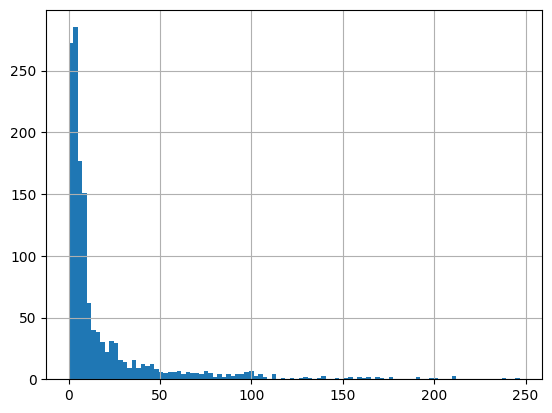

In [124]:
ab['Abs_err_for_total-energy'].hist(bins=100)

In [125]:
# Cluster the test data
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score

X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)


# Create a KMeans model with 2 clusters: model
kmans = KMeans(n_clusters=3, random_state=42)
kmans.fit(X_test_normalized)

# Use the .predict() method to predict the labels of X: labels
labels = kmans.predict(X_test_normalized)

# Calculate the silhouette_score
silhouette_score(X_test_normalized, labels)

c:\ProgramData\Anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



0.9423977877020634

PCA explained variance: [0.32986406 0.16897942]. Sum: 0.4988434771042602
(1392, 16)


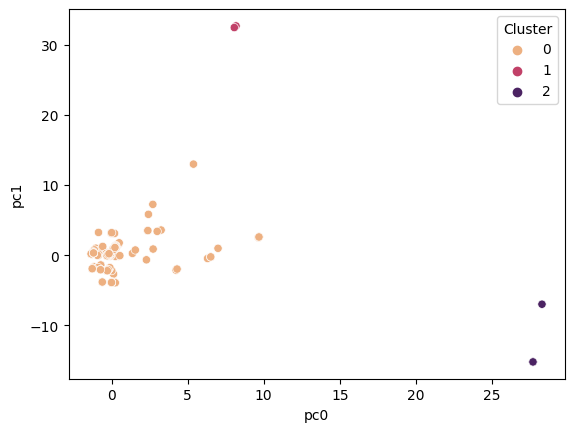

In [126]:
# Now we will try to visualize the clusters in 2D
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns
import matplotlib.pyplot as plt

# Create a PCA instance: pca
pca = PCA(n_components=2)

# Fit the PCA instance to the samples
pca.fit(X_train_normalized)

# Transform the samples: pca_features
pca_features = pca.transform(X_test_normalized)

# Print how much of the variance is explained by the first two components
print(f'PCA explained variance: {pca.explained_variance_ratio_}. Sum: {sum(pca.explained_variance_ratio_)}')

# Create a DataFrame with the two columns: df
df = pd.DataFrame(pca_features, columns=['pc0', 'pc1']).reset_index(drop=True)
df = pd.concat([df, ab], axis=1)
print(df.shape)

# Create a scatter plot of the two columns
sns.scatterplot(x='pc0', y='pc1', data=df, hue=labels, palette='flare')
# Add label to legend
plt.legend(title='Cluster')

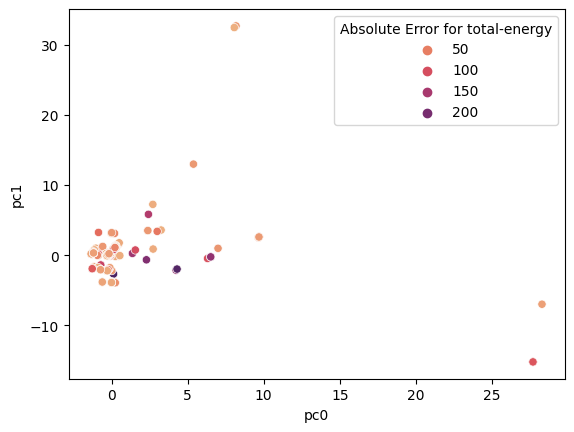

In [127]:
# Visualize test absolute errors on principal components

# Create a scatter plot of the two columns
sns.scatterplot(x='pc0', y='pc1', data=df, hue='Abs_err_for_total-energy', palette='flare')
# Add label to legend
plt.legend(title='Absolute Error for total-energy')

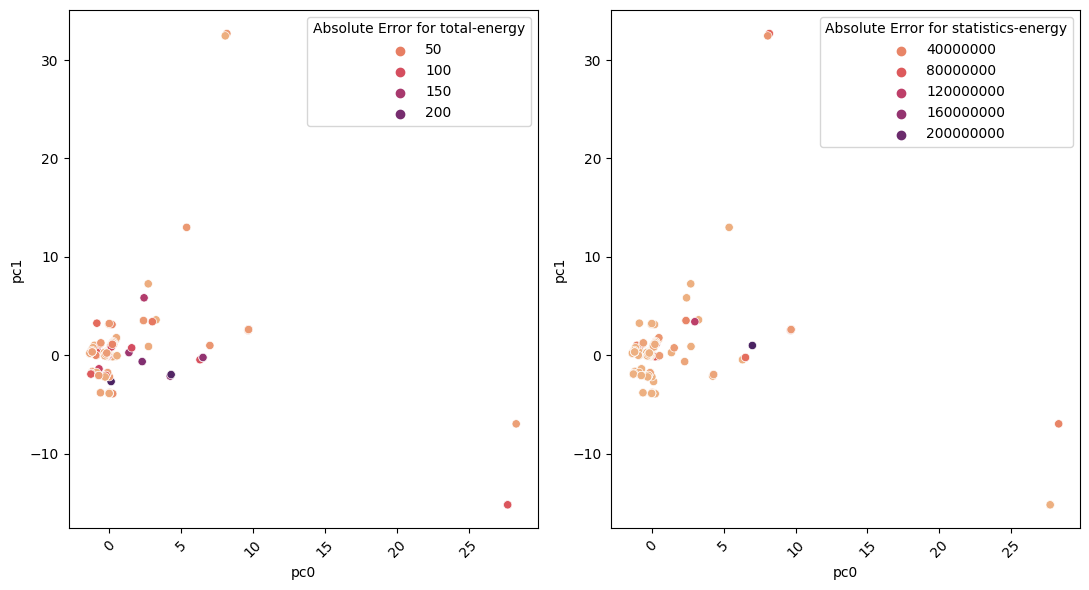

In [128]:
# Plot errors for both targets on the same plot dependent on the principal components
fig, ax = plt.subplots(1, 2, figsize=(11, 6))
sns.scatterplot(x='pc0', y='pc1', data=df, hue='Abs_err_for_total-energy', palette='flare', ax=ax[0])
sns.scatterplot(x='pc0', y='pc1', data=df, hue='Abs_err_for_statistics-energy', palette='flare', ax=ax[1])
# Add label to legend
ax[0].legend(title='Absolute Error for total-energy')
ax[1].legend(title='Absolute Error for statistics-energy')

# Rotate xticks for better readability
plt.setp(ax[0].get_xticklabels(), rotation=45)
plt.setp(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()

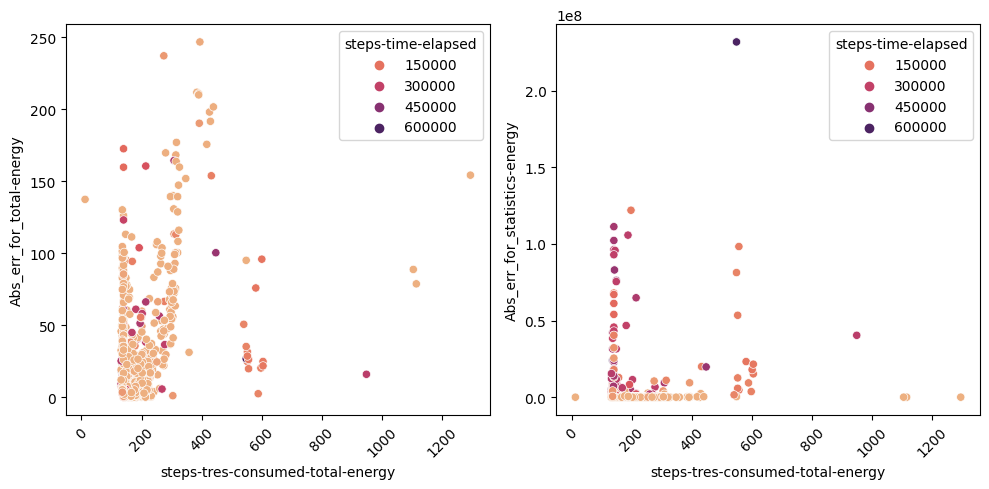

In [129]:
# Plot errors for both targets as y on the same plot dependent on steps-time-elapsed as x
_df = pd.concat([ab, y_test], axis=1).reset_index(drop=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
hue = 'steps-time-elapsed'
x = 'steps-tres-consumed-total-energy'
y = 'Abs_err_for_total-energy'
sns.scatterplot(x=x, y=y, data=_df, hue=hue, palette='flare', ax=ax[0])
y = 'Abs_err_for_statistics-energy'
sns.scatterplot(x=x, y=y, data=_df, hue=hue, palette='flare', ax=ax[1])

# Rotate xticks for better readability
plt.setp(ax[0].get_xticklabels(), rotation=45)
plt.setp(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()


3D visualizations

In [130]:
# 3D pca 
pca3d = PCA(n_components=3)
pca3d.fit(X_test_normalized)
pca3d_features = pca3d.transform(X_test_normalized)

# Print how much of the variance is explained by the first two components
print(f'PCA explained variance: {pca3d.explained_variance_ratio_}. Sum: {sum(pca3d.explained_variance_ratio_)}')

# Create DataFrame
df3d = pd.DataFrame(pca3d_features, columns=['pc0', 'pc1', 'pc2']).reset_index(drop=True)

# Add absolute errors and labels
df3d = pd.concat([df3d, ab, y_test], axis=1)
print(df3d.shape)

# Plot 3D pca with plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

color_attributes = [
    'Abs_err_for_total-energy', 
    'Abs_err_for_statistics-energy', 
    'steps-tres-consumed-total-energy', 
    'steps-statistics-energy-consumed',
    'Predicted_for_total-energy',
    'Predicted_for_statistics-energy',
    'Error_total-energy',
    'Error_statistics-energy',
    # 'allocation_nodes',
    # 'steps-time-elapsed', 
    # 'required-memory'
    ]
for color_attri in color_attributes:
    print(f'Plotting 3D pca with {color_attri} as color attribute')
    fig = px.scatter_3d(df3d, x='pc0', y='pc1', z='pc2', color=color_attri, opacity=0.9)
    fig.update_traces(marker_size = 8)
    fig.show()

PCA explained variance: [0.33900965 0.31134175 0.1023668 ]. Sum: 0.7527181986978861
(1392, 19)
Plotting 3D pca with Abs_err_for_total-energy as color attribute
Plotting 3D pca with Abs_err_for_statistics-energy as color attribute
Plotting 3D pca with steps-tres-consumed-total-energy as color attribute
Plotting 3D pca with steps-statistics-energy-consumed as color attribute
Plotting 3D pca with Predicted_for_total-energy as color attribute
Plotting 3D pca with Predicted_for_statistics-energy as color attribute
Plotting 3D pca with Error_total-energy as color attribute
Plotting 3D pca with Error_statistics-energy as color attribute


Correlation

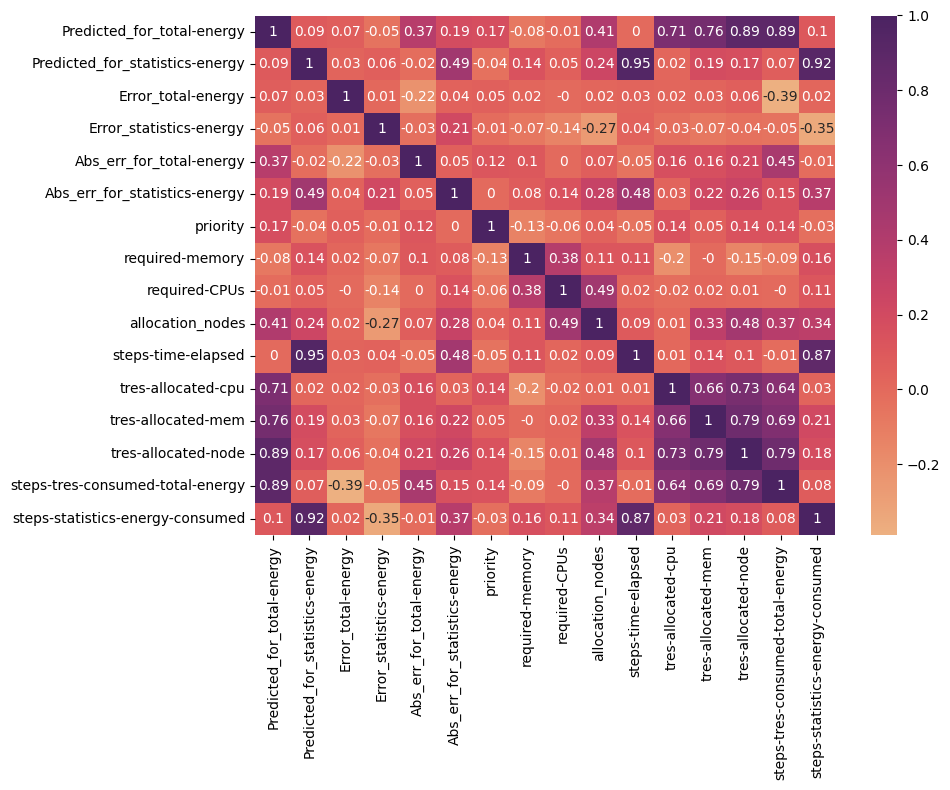

In [131]:
# Plot errors correlation with X_test features and y_test
corr_df = pd.concat([ab, y_test], axis=1)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_df.corr().round(2), annot=True, cmap='flare')
plt.tight_layout()

In [132]:
ab_sorted = pd.concat([ab, y_test], axis=1)
ab_sorted = ab_sorted.sort_values(by='Abs_err_for_total-energy', ascending=False)
ab_sorted.head(10)

,Predicted_for_total-energy,Predicted_for_statistics-energy,Error_total-energy,Error_statistics-energy,Abs_err_for_total-energy,Abs_err_for_statistics-energy,priority,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node,steps-tres-consumed-total-energy,steps-statistics-energy-consumed
94,147.298261,4.091611e+06,-246.701739,-2.041970e+05,246.701739,2.041970e+05,8230.0,122880.0,24.0,1.0,15981.0,48.0,65536.0,1.0,394.0,4295808.0
934,511.066667,1.056571e+07,237.066667,1.056571e+07,237.066667,1.056571e+07,23.0,102400.0,28.0,1.0,59056.0,96.0,196608.0,2.0,274.0,0.0
187,172.258770,1.481181e+05,-211.741230,1.481181e+05,211.741230,1.481181e+05,6.0,122880.0,28.0,1.0,581.0,28.0,122880.0,1.0,384.0,0.0
609,179.322500,1.485750e+05,-210.677500,-3.401098e+04,210.677500,3.401098e+04,6.0,122880.0,28.0,1.0,537.0,28.0,122880.0,1.0,390.0,182586.0
988,180.059008,1.485750e+05,-209.940992,-2.060975e+03,209.940992,2.060975e+03,6.0,122880.0,28.0,1.0,541.0,28.0,122880.0,1.0,390.0,150636.0
993,237.413300,2.664059e+06,-201.586700,-3.526968e+05,201.586700,3.526968e+05,9.0,122880.0,28.0,1.0,7014.0,28.0,122880.0,1.0,439.0,3016756.0
198,227.969944,2.498105e+06,-198.030056,-4.909107e+04,198.030056,4.909107e+04,9.0,122880.0,28.0,1.0,7499.0,28.0,122880.0,1.0,426.0,2547196.0
657,237.413300,2.436596e+06,-191.586700,2.353772e+06,191.586700,2.353772e+06,9.0,122880.0,28.0,1.0,7005.0,28.0,122880.0,1.0,429.0,82824.0
1323,201.756410,3.929534e+05,-190.243590,-9.426331e+06,190.243590,9.426331e+06,23.0,102400.0,28.0,1.0,49895.0,48.0,163840.0,2.0,392.0,9819284.0
163,139.051615,2.554874e+06,-176.948385,1.645802e+05,176.948385,1.645802e+05,9.0,122880.0,28.0,1.0,7047.0,28.0,102400.0,1.0,316.0,2390294.0


In [133]:
ab_sorted.tail(10)

,Predicted_for_total-energy,Predicted_for_statistics-energy,Error_total-energy,Error_statistics-energy,Abs_err_for_total-energy,Abs_err_for_statistics-energy,priority,required-memory,required-CPUs,allocation_nodes,steps-time-elapsed,tres-allocated-cpu,tres-allocated-mem,tres-allocated-node,steps-tres-consumed-total-energy,steps-statistics-energy-consumed
212,144.025065,451380.120097,0.025065,-15235.879903,0.025065,15235.879903,108.0,102400.0,28.0,1.0,3107.0,28.0,102400.0,1.0,144.0,466616.0
396,144.025065,451380.120097,0.025065,-25443.879903,0.025065,25443.879903,108.0,102400.0,28.0,1.0,3092.0,28.0,102400.0,1.0,144.0,476824.0
177,144.025065,451380.120097,0.025065,-3995.879903,0.025065,3995.879903,108.0,102400.0,28.0,1.0,3117.0,28.0,102400.0,1.0,144.0,455376.0
675,144.025065,451380.120097,0.025065,8706.120097,0.025065,8706.120097,108.0,102400.0,28.0,1.0,3113.0,28.0,102400.0,1.0,144.0,442674.0
16,144.025065,451380.120097,0.025065,-35975.879903,0.025065,35975.879903,108.0,102400.0,28.0,1.0,3107.0,28.0,102400.0,1.0,144.0,487356.0
856,167.979936,538125.965203,-0.020064,-12914.034797,0.020064,12914.034797,17.0,122880.0,28.0,1.0,2961.0,28.0,122880.0,1.0,168.0,551040.0
159,167.979936,538125.965203,-0.020064,-14442.034797,0.020064,14442.034797,17.0,122880.0,28.0,1.0,2967.0,28.0,122880.0,1.0,168.0,552568.0
328,144.987363,451380.120097,-0.012637,-8089.879903,0.012637,8089.879903,108.0,102400.0,28.0,1.0,3134.0,28.0,102400.0,1.0,145.0,459470.0
601,140.992047,469000.755040,-0.007953,12872.755040,0.007953,12872.755040,108.0,102400.0,28.0,1.0,3233.0,28.0,102400.0,1.0,141.0,456128.0
93,166.998844,721318.624783,-0.001156,-9231.375217,0.001156,9231.375217,17.0,122880.0,28.0,1.0,2517.0,28.0,122880.0,1.0,167.0,730550.0
